# Fitting Proteins

In [212]:
import os
import itertools
import glob
import parmed
from simtk.openmm import app
from simtk import unit
from oeommtools import utils as oeo_utils
from chemper.smirksify import SMIRKSifier
from chemper.graphs.cluster_graph import ClusterGraph
import copy
import random
from collections import OrderedDict

In [213]:
from openeye import oechem, oeomega, oedepict
import IPython
from IPython.display import display, Image

alpha_list = [255, 51, 153]
final_colors = list()

for a in alpha_list:
    for c in oechem.OEGetContrastColors():
        temp_c = c.CreateCopy()
        temp_c.SetA(a)
        final_colors.append(temp_c)

def depictMatch(mol, match=None, supH = True, idx_atoms=list(), width=500, height=200, fn=None,
               color1=oechem.OELightBlue, color2=oechem.OELightSalmon, include_bonds=True):
    
    atom_bond_set = oechem.OEAtomBondSet()
    for atom in mol.GetAtoms():
        if atom.GetIdx() in idx_atoms:
            atom_bond_set.AddAtom(atom)
            if not include_bonds:
                continue
            for bond in atom.GetBonds():
                nbr_atom = bond.GetNbr(atom)
                if (nbr_atom.GetIdx() in idx_atoms) and nbr_atom.GetIdx() > atom.GetIdx():
                    atom_bond_set.AddBond(bond)
    
    dopt = oedepict.OEPrepareDepictionOptions()
    dopt.SetDepictOrientation( oedepict.OEDepictOrientation_Horizontal)
    dopt.SetSuppressHydrogens(supH)
    oedepict.OEPrepareDepiction(mol, dopt)
    
    opts = oedepict.OE2DMolDisplayOptions(width, height, oedepict.OEScale_AutoScale)
    opts.SetAtomColorStyle(oedepict.OEAtomColorStyle_WhiteMonochrome)
    disp = oedepict.OE2DMolDisplay(mol, opts)
    
    # Highlight indexed atoms
    hstyle = oedepict.OEHighlightStyle_Cogwheel
    hcolor = oechem.OEColor(color1)
    if not atom_bond_set.IsEmpty():
        oedepict.OEAddHighlighting(disp, hcolor, hstyle, atom_bond_set)
    
    if match is not None:
        # Highlight whole match
        hstyle = oedepict.OEHighlightStyle_BallAndStick
        hcolor = oechem.OEColor(color2)
        oedepict.OEAddHighlighting(disp, hcolor, hstyle, match)
    
    img = oedepict.OEImage(width, height)
    oedepict.OERenderMolecule(img,disp)
    
    if fn is not None:
        ext = oechem.OEGetFileExtension(fn)
        if oedepict.OEIsRegisteredImageFile(ext):
            ofs = oechem.oeofstream()
            if not ofs.open(fn):
                print("OE could not open file due to error %s" % fn)
                ofs.close()
            else:
                oedepict.OERenderMolecule(ofs, ext, disp)
                ofs.close()
        else:
            print("OE could not handle extension on %s" % fn)
    return img

# Load systems into openMM systems

Here is what I would like to track and my planned structure:

What information do we need:

* quantitative parameters:
    - with units and "full values"
    - rounded within 0.001? to identify when parameters should be treated the same
* atom indices which will translate into OEmols with `oeommtools`
    - by parameter type
* parmed/openmm systems to make the oemols

#### What is the best way to store this data?

How to store this data isn't necessarily obvious, but this is what I'm thinking right now:

Dictionaries by parameter type with the setup:

* keys: string of quantitative parameters rounded to assigned values with two sub dictionaries:
    - 'atom indices': dictioanry with form {mol_num/id: list of atom indice tuples}
        * I think it makes more sense to keep these as dictionaries for now so that we can also have a {mol_num/id: molecule} dictionary that can be translated into the chemper format later
    - 'parameters': set of tuples so that if there are differences in rounding to the top string we can track them down and so we can store the units that go with each component

Separate dictionary with the molecules stored with the form `{mol_num/id: { 'oemol': oemol, 'parmed': parmed_system} }`. I think for a first pass it is worth storing both objects just in case, but ultimately we only really need to the oemol after the first set of dictionaries is done.

In [214]:
class parameter_dict:
    
    def __init__(self):
        self.d = dict()
    
    def items(self):
        return self.d.items()
    
    def add_key(self, key):
        if key not in self.d:
            self.d[key] = {'atom_indices': dict(), 'parameters': set(), 'units': None}
    
    def add_atoms(self, key, mol_id, atom_tuple):
        self.add_key(key)
        if mol_id not in self.d[key]['atom_indices']:
            self.d[key]['atom_indices'][mol_id] = list()
        self.d[key]['atom_indices'][mol_id].append(tuple(atom_tuple))
    
    def add_param(self, key, params):
        self.add_key(key)
        new_tuple = [x._value for x in params]
        self.d[key]['parameters'].add(tuple(new_tuple))
        self.d[key]['units'] = tuple([x.unit for x in params])

In [215]:
class parameter_system(object):
    
    def __init__(self, openmm_xml='amber14-all.xml'):
        self.openmm_xml = openmm_xml
        self.lj_dict = parameter_dict()
        self.charge_dict = parameter_dict()
        self.bond_dict = parameter_dict()
        self.angle_dict = parameter_dict()
        self.proper_dict = parameter_dict()
        self.improper_dict = parameter_dict()
        self.mol_dict = dict()
    
    def add_system_from_fasta(self, fasta):
        base = os.path.abspath(fasta).split('.')[0]
        mol_id = base.split('/')[-1]

        oemol = oechem.OEMol()
        ifs = oechem.oemolistream(fasta)

        oechem.OEReadFASTAFile(ifs,oemol)
        oechem.OEAddExplicitHydrogens(oemol)

        oechem.OEPerceiveResidues(oemol)
        oechem.OEPDBOrderAtoms(oemol)

        ofs = oechem.oemolostream()
        ofs.SetFormat(oechem.OEFormat_PDB)
        ofs.openstring()
        oechem.OEWriteMolecule(ofs,oemol)

        ifs = oechem.oemolistream()
        ifs.openstring(ofs.GetString())
        m = oechem.OEMol()
        oechem.OEReadPDBFile(ifs,m)
        #oechem.OEReadMolecule(ifs,m)
        m.SetTitle(mol_id)
        top = oeo_utils.oemol_to_openmmTop(m)[0]
        ff = app.ForceField(self.openmm_xml)
        protein_sys = ff.createSystem(top)
        parm = parmed.openmm.load_topology(top, protein_sys)
        
        oechem.OEAssignFormalCharges(m)
        self.mol_dict[mol_id] = {
            'parmed': parm,
            'oemol': oechem.OEMol(m)
        }
        self._add_parameters_from_system(parm, mol_id)
        
        return parm, m
    
    def add_system_from_amber(self, prm_file, inp_file, pdb):
        """
        Adds an amber system to the clusters of parameters stored here.
        All parameters are added to relevant dictionary and returns the system
        
        Parameters
        ----------
        prm_file: path to AMBER prmtop file
        inp_file: path to AMBER inpcrd file
    
        Returns
        -------
        sys: parmed system created from these files
        """
        parm = parmed.load_file(prm_file, inp_file)
        base = prm_file.split('.')[0]
        mol_id = base.split('/')[-1]
        self.mol_dict[mol_id] = {'parmed': parm, 
                                   'oemol': oeo_utils.openmmTop_to_oemol(sys.topology, sys.positions)}
        self._add_parameters_from_system(parm,mol_id)
        return parm
    
    def _add_parameters_from_system(self, sys, mol_id):
        self.add_nonbonds(sys, mol_id)
        self.add_bonds(sys, mol_id)
        self.add_angles(sys, mol_id)
        self.add_torsions(sys, mol_id)
        
    def add_nonbonds(self, sys, mol_id):
        """
        Cluster atoms based on their partial charge

        Parameters
        ----------
        sys: list like of parmed system
        charge_dict: dictionary to store data that will be updated in this function
        lj_dict: dictionary to store LJ parameters for this molecule
        mol_id: key for this system to store data in the dictionaries

        Returns
        -------
        clusters: dictionary with the form
                  {string parameter: {'atom_idices': {}}
        """    
        if mol_id not in self.mol_dict:
            self.add_molecule(sys, mol_id)
            
        for a in sys.atoms:
            # Update charge dictionary:
            charge_str = "%.5f" % a.charge
            charge_param = [a.ucharge]
            self.charge_dict.add_param(charge_str, charge_param)
            self.charge_dict.add_atoms(charge_str, mol_id, [a.idx])

            # Update LJ dictionary
            lj_str = "%.3f\t%.3f" % (a.epsilon, a.rmin)
            lj_params = [a.uepsilon, a.urmin]
            self.lj_dict.add_param(lj_str, lj_params)
            self.lj_dict.add_atoms(lj_str, mol_id, [a.idx])

    def add_bonds(self, sys, mol_id):
        if mol_id not in self.mol_dict:
            self.add_molecule(sys, mol_id)
        for b in sys.bonds:
            bond_str = "%.3f\t%.3f" % (b.type.k, b.type.req)
            bond_params = [b.type.uk, b.type.ureq]
            self.bond_dict.add_param(bond_str, bond_params)
            self.bond_dict.add_atoms(bond_str, mol_id, [b.atom1.idx, b.atom2.idx])
        
    def add_angles(self, sys, mol_id):
        if mol_id not in self.mol_dict:
            self.add_molecule(sys, mol_id)
        for an in sys.angles:
            angle_str = "%.3f\t%.3f" % (an.type.k, an.type.theteq)
            angle_params = [an.type.uk, an.type.utheteq]
            self.angle_dict.add_param(angle_str, angle_params)
            self.angle_dict.add_atoms(angle_str, mol_id, [an.atom1.idx, an.atom2.idx, an.atom3.idx])
    
    def convert_for_smirksifying(self, param_type=None):
        """
        param_type: string specifying the parameter you want clusters for
        must chose from ['lj', 'charge', 'proper_torsion', 'improper_torsion', 'angle', 'bond']
        
        Returns
        -------
        - list of molecules
        - either dictionary or list of clustered atomic indices
        
        """
        idx_list = list()
        mol_list = list()
        cluster_types = dict()
        
        dictionaries = {
            'lj': self.lj_dict,
            'charge': self.charge_dict,
            'proper_torsion': self.proper_dict,
            'improper_torsion': self.improper_dict,
            'angle': self.angle_dict,
            'bond': self.bond_dict,
        }
        
        if param_type is not None:
            if param_type.lower() not in dictionaries.keys():
                return cluster_types
            dictionaries = {param_type.lower(): dictionaries[param_type.lower()]}
        
        for idx, me in self.mol_dict.items():
            idx_list.append(idx)
            mol_list.append(me['oemol'])
        
        for label, par_dict in dictionaries.items():
            cluster_types[label] = list()
            for cluster_label, entry in par_dict.items():
                atom_list = list()
                for idx in idx_list:
                    if idx in entry['atom_indices']:
                        atom_list.append(entry['atom_indices'][idx])
                    else:
                        atom_list.append(list())
                cluster_types[label].append((cluster_label, atom_list))

        if param_type is None:
            return mol_list, cluster_types
        
        return mol_list, cluster_types[param_type.lower()]

    def add_torsions(self, sys, mol_id):
        if mol_id not in self.mol_dict:
            self.add_molecule(sys, mol_id)
        temp_dict = dict()
        for d in sys.dihedrals:
            if d.improper:
                imp_str = "%.3f\t%.3f\t%.3f" % (d.type.phi_k, d.type.phase, d.type.per)
                imp_params = [d.type.uphi_k, d.type.uphase, unit.Quantity(d.type.per)]
                self.improper_dict.add_param(imp_str, imp_params)
                self.improper_dict.add_atoms(imp_str, mol_id, [d.atom1.idx, d.atom3.idx, d.atom2.idx, d.atom4.idx])
            else:
                atoms = tuple([d.atom1.idx, d.atom2.idx, d.atom3.idx, d.atom4.idx])
                params = (d.type.uphi_k, d.type.uphase, unit.Quantity(d.type.per))
                if atoms not in temp_dict:
                    temp_dict[atoms] = list()
                temp_dict[atoms].append(params)

        for atoms, param_list in temp_dict.items():
            new_params = [p for t in param_list for p in t]
            prop_str = '\t'.join(['%.3f' % p._value for p in new_params])
            self.proper_dict.add_param(prop_str, new_params)
            self.proper_dict.add_atoms(prop_str, mol_id, atoms)

# EXAMPLE using fasta works for one dipeptide

Now I need to automate looping over single amino acid codes to make a full set of molecules

2.500	180.000	2.000
--------------------------------------------------------------------------------
0 0


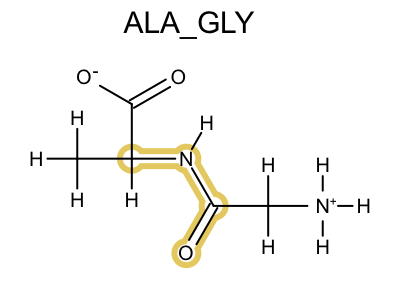

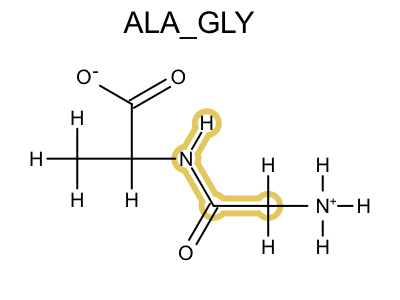

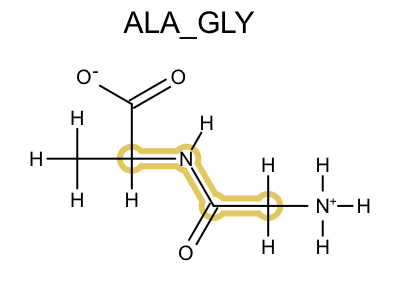

0.420	0.000	3.000	0.270	0.000	2.000
--------------------------------------------------------------------------------
0 0


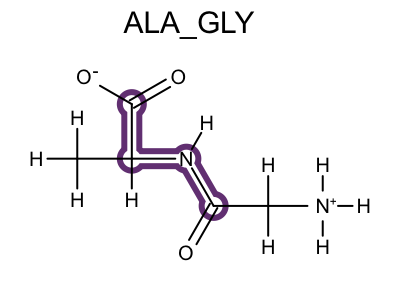

2.500	180.000	2.000	2.000	0.000	1.000
--------------------------------------------------------------------------------
0 0


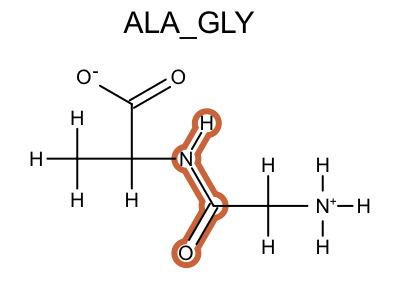

0.156	0.000	3.000
--------------------------------------------------------------------------------
0 0


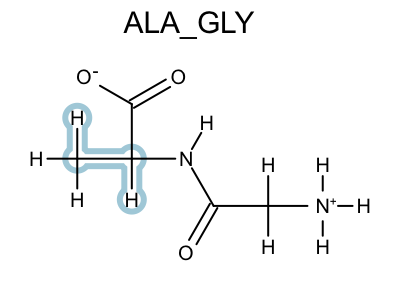

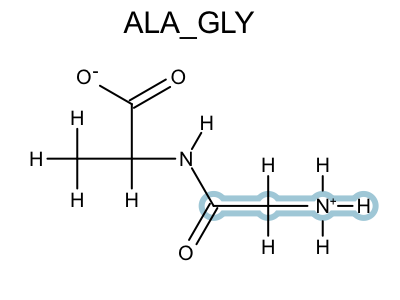

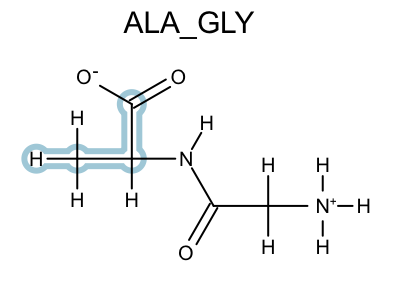

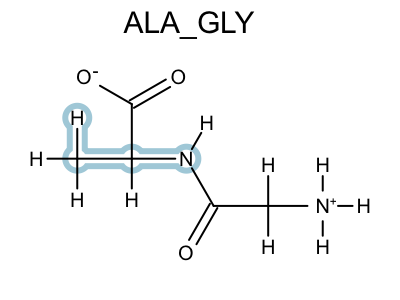

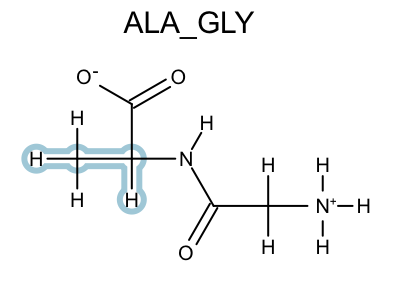

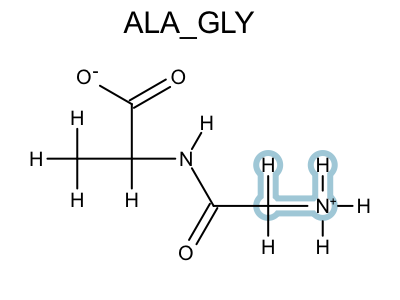

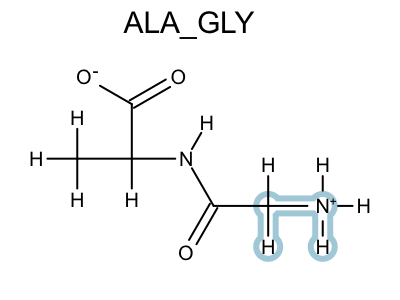

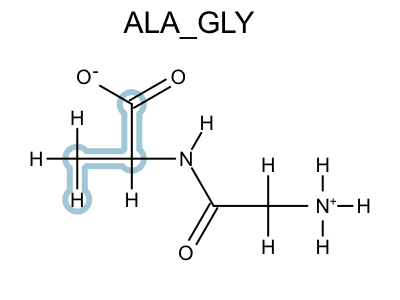

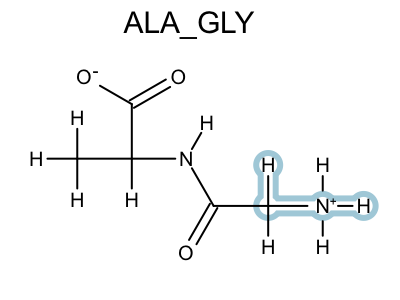

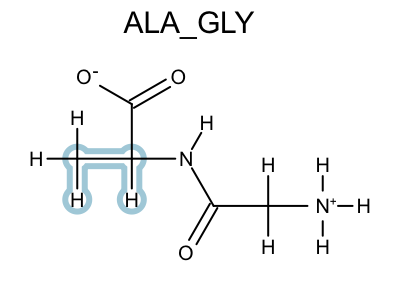

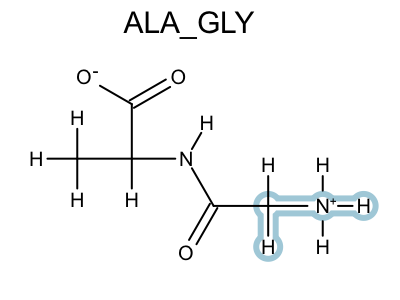

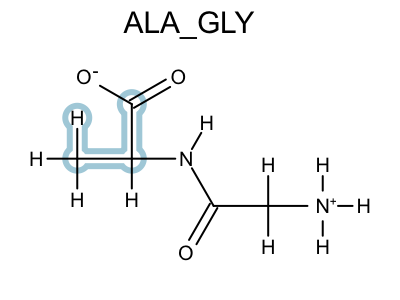

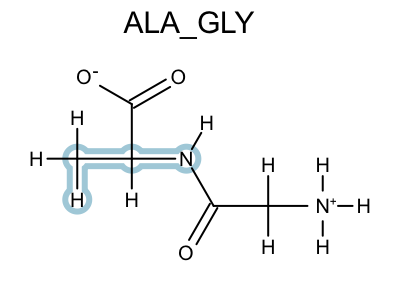

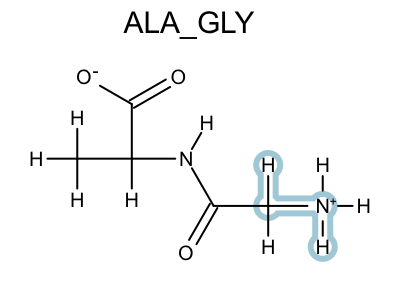

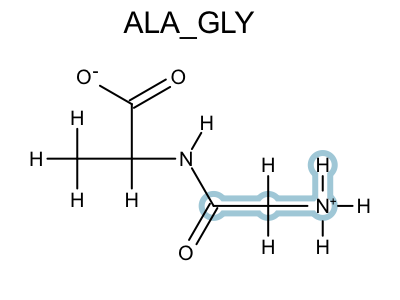

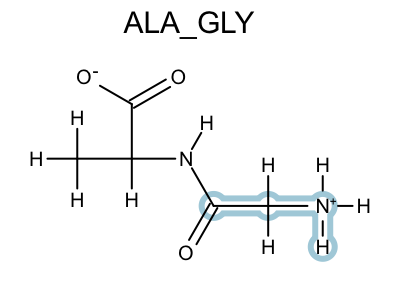

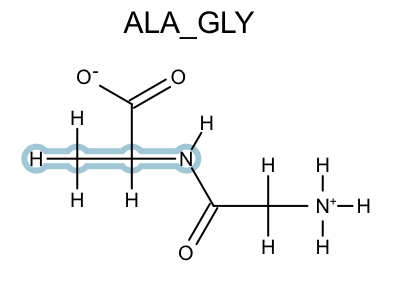

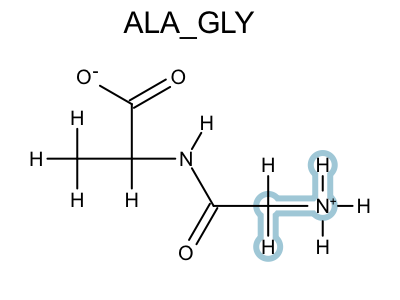

0.400	0.000	3.000	2.000	0.000	2.000	2.000	0.000	1.000
--------------------------------------------------------------------------------
0 0


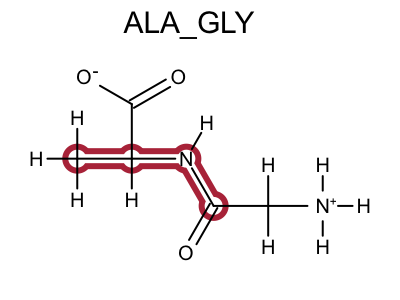

In [216]:
for c_idx, (p_lab, cluster) in enumerate(ctypes['proper_torsion']):
    print(p_lab)
    color = final_colors[c_idx]
    for mol_idx, atom_indice_list in enumerate(cluster):
        if len(atom_indice_list) == 0:
            continue
        print('-'*80)
        m = oechem.OEMol(ms[mol_idx])
        aros = [atom for atom in m.GetAtoms() if atom.IsAromatic()]
        print(mol_idx, oechem.OECount(m, oechem.OEIsAromaticAtom())) 
            
        
        #m.SetTitle(p_lab)
        for a_idx, a in enumerate(atom_indice_list):
            img = depictMatch(m, supH=False, idx_atoms=a, color1=color, width=400, height=300)
            display(Image(oedepict.OEWriteImageToString("png",img)))

# Organize all of this into one/a few functions so that you can easily call the whole thing

In [217]:
def change_order_smirksified(mols, cluster_types, order_type_names=['shuffle'], smirks_verbose=False):
    """
    Returns smirs_order_types object
    """
    def reverse_clusters(clusters):
        return list(reversed(clusters))

    def shuffle(clusters):
        tempc = copy.deepcopy(clusters)
        random.shuffle(tempc)
        return tempc

    def by_smallest_size(clusters):
        return sorted(clusters, key=lambda x: len([a for l in x[1] for a in l]))

    def by_smallest_num_molecule(clusters):
        tempc = sorted(clusters, key=lambda x: len([1 for l in x[1] if len(l) > 0]))
        return tempc

    def by_biggest_size(clusters):
        return reverse_clusters(by_smallest_size(clusters))

    def by_biggest_num_molecule(clusters):
        return reverse_clusters(by_smallest_num_molecule(clusters))

    def by_smallest_smirks(clusters):
        tempc = sorted(clusters, key=lambda x: len(ClusterGraph(mols,x[1]).as_smirks()))
        return tempc

    def by_biggest_smirks(clusters):
        return reverse_clusters(by_smallest_smirks(clusters))

    smirs_order_types = dict()
    
    order_types_dict = {'original':None,
        'reversed': reverse_clusters,
        'shuffle': shuffle,
        'small_size': by_smallest_size,
        'biggest_size': by_biggest_size,
        'fewest_mols': by_smallest_num_molecule,
        'most_mols': by_biggest_num_molecule,
        'small_smirks': by_smallest_smirks,
        'big_smirks': by_biggest_smirks}
    
    order_types = list()
    for n in set(order_type_names):
        ofunct = order_types_dict.get(n,None)
        order_types.append((n, ofunct))
        for i in range(1,order_type_names.count(n)):
            temp_n = '%s_%i' % (n,i)
            order_types.append((temp_n, ofunct))
    
    for otype, ofunct in order_types:
        print(otype)
        smirs_order_types[otype] = dict()
        for label, clusters in cluster_types.items():
            if ofunct is None:
                oclusters = clusters
            else:
                oclusters = ofunct(clusters)
            try: 
                smirs_order_types[otype][label] = SMIRKSifier(mols, oclusters, max_layers=10, 
                                                              strict_smirks=False, verbose=smirks_verbose)
            except Exception as e: 
                smirs_order_types[otype][label] = e
                
    return smirs_order_types
                
def print_order_type_data(smirs_order_types, print_all=True):
    for otype, smirs in smirs_order_types.items():
        final_print = ''
        all_passed = True
        for label, output in smirs.items():
            if not output.checks:
                final_print += '%-23s FAILED to make smirks\n' % (label)
                all_passed = False
            else:
                final_print += '%-23s PASSED\n' % (label)

        if all_passed:
            print('-'*80)
            print('%-23s ALL PASSED' % otype)
            print('-'*80)
            print(final_print)
        elif print_all:
            print('-'*80)
            print(otype)
            print('-'*80)
            print(final_print)

def everything_from_fastas(list_fastas, protein_xml='amber14-all.xml', order_type_names=['shuffle'], verbose=True):
    """ 
    Parameters
    ----------
    list_fastas: list of str
                 list of full paths to .fasta files with peptide sequences
    
    protein_xml: str
                 file name or complete path to a openMM .xml file for assign protein parameters
                 
    order_type_names: list of str 
    
    Returns
    -------
    data_storage: parameter_sytem object
                  parameter_system storing the parameterized molecules and clusters
                  by parameter type from the provided fasta files
    smirs_order_types: dictionary with the form...
            {
            order type (ie 'shuffle' or 'smallest_size): {
                param_type (ie 'proper_torsion'): SMIRKSifier object (even if it failed)
                }
            }
    """
    store_data = parameter_system(openmm_xml=protein_xml)
    for fasta in list_fastas:
        parm, oemol = store_data.add_system_from_fasta(fasta)
    mols, cluster_types = store_data.convert_for_smirksifying()
    
    if verbose:
        table_form = "%-20s %-10s %-10s %s"
        print('='*80)
        print(table_form % ('parameter', 'mols', 'clusters', 'mols in clusters'))
        print('-'*80)
        for label, clusters in cluster_types.items():
            print(table_form % (label, len(mols), len(clusters), len(clusters[0][1])))
        print('='*80)
    
    smirs_order_types = change_order_smirksified(mols, cluster_types, order_type_names=order_type_names)
    if verbose: print_order_type_data(smirs_order_types)
    
    return store_data, smirs_order_types

# Make fasta files

In [218]:
singles = ['G', 'A', 'V', 'L', 'I', 'M', 'F', 'W', 'P', 'S', 'T', 'C', 'Y', 'N', 'Q', 'D', 'E', 'K', 'R', 'H']

In [219]:
def make_di_fasta_file(pair, directory):
    p1, p2 = pair
    fasta_str = """>%s%s
%s%s
""" % (p1, p2, p1, p2)
    fn = '%s/%s_%s.fasta' % (directory, p1,p2)
    
    f = open(fn,'w')
    f.write(fasta_str)
    f.close()

In [220]:
directory = os.path.abspath("./mol_files/")
for p in itertools.combinations(singles, 2):
    make_di_fasta_file(p,directory)

In [221]:
cwd = os.getcwd()
fastas = glob.glob('%s/mol_files/*.fasta' % cwd)

In [223]:
names = ['shuffle','biggest_size', 'most_mols', 'big_smirks']
data_store2, smirs_order_types2 = everything_from_fastas(fastas[:2], verbose=False, order_type_names=names)

biggest_size
shuffle
WARNING! 
                      SMIRKSifier was not able to create SMIRKS for the provided
                      clusters with 10 layers. Try increasing the number of layers
                      or changing your clusters
                      
small_smirks
WARNING! 
                      SMIRKSifier was not able to create SMIRKS for the provided
                      clusters with 10 layers. Try increasing the number of layers
                      or changing your clusters
                      
most_mols
small_size
WARNING! 
                      SMIRKSifier was not able to create SMIRKS for the provided
                      clusters with 10 layers. Try increasing the number of layers
                      or changing your clusters
                      
fewest_mols
WARNING! 
                      SMIRKSifier was not able to create SMIRKS for the provided
                      clusters with 10 layers. Try increasing the number of layers
                      or

In [225]:
print_order_type_data(smirs_order_types2, print_all=False)

--------------------------------------------------------------------------------
biggest_size            ALL PASSED
--------------------------------------------------------------------------------
angle                   PASSED
lj                      PASSED
proper_torsion          PASSED
improper_torsion        PASSED
bond                    PASSED
charge                  PASSED

--------------------------------------------------------------------------------
most_mols               ALL PASSED
--------------------------------------------------------------------------------
angle                   PASSED
lj                      PASSED
proper_torsion          PASSED
improper_torsion        PASSED
bond                    PASSED
charge                  PASSED

--------------------------------------------------------------------------------
big_smirks              ALL PASSED
--------------------------------------------------------------------------------
angle                   PASSED
lj  

In [226]:
print_order_type_data(smirs_order_types2)

--------------------------------------------------------------------------------
biggest_size            ALL PASSED
--------------------------------------------------------------------------------
angle                   PASSED
lj                      PASSED
proper_torsion          PASSED
improper_torsion        PASSED
bond                    PASSED
charge                  PASSED

--------------------------------------------------------------------------------
most_mols               ALL PASSED
--------------------------------------------------------------------------------
angle                   PASSED
lj                      PASSED
proper_torsion          PASSED
improper_torsion        PASSED
bond                    PASSED
charge                  PASSED

--------------------------------------------------------------------------------
small_smirks
--------------------------------------------------------------------------------
angle                   PASSED
lj                      PA

# ==================================================

# storing systems in Json files and writing converters

In [177]:
data_store = data_store2
smirs_order_types = smirs_order_types2
#def store_in_json(data_store, smirs_order_types):

biggest_size
most_mols
shuffle
WARNING! 
                      SMIRKSifier was not able to create SMIRKS for the provided
                      clusters with 10 layers. Try increasing the number of layers
                      or changing your clusters
                      
shuffle_1
WARNING! 
                      SMIRKSifier was not able to create SMIRKS for the provided
                      clusters with 10 layers. Try increasing the number of layers
                      or changing your clusters
                      
shuffle_2
WARNING! 
                      SMIRKSifier was not able to create SMIRKS for the provided
                      clusters with 10 layers. Try increasing the number of layers
                      or changing your clusters
                      
big_smirks
